# MAF vs lead variant VEP score

This notebook compares the MAF (Minor Allele Frequency) of credible set lead variants with their VEP (Variant Effect Predictor) scores

In [1]:
from __future__ import annotations

import random
from collections.abc import Callable

import polars as pl
import seaborn as sns

random.seed(42)
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("coolwarm"))
pl.Config.set_tbl_rows(100)


polars.config.Config

## Methods

In [10]:
def classify_by_pip_threshold(pip: pl.Expr, threshold: float = 0.9) -> pl.Expr:
    """Classify dataset by posteriorProbability threshold."""
    return pl.when(pip >= threshold).then(True).otherwise(False).alias(f"is{threshold * 100:.0f}pip")


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


class VariantFrequencyGroup:
    def __init__(self, condition: Callable[[pl.Expr], pl.Expr], label: str) -> None:
        self.label = label
        self.condition = condition


def classify_by_altering(vep_score: pl.Expr) -> pl.Expr:
    """Classify variants based on altering status."""
    expr = pl.when(vep_score.struct.field("normalisedScore") >= 0.66).then(pl.lit("protein_altering"))
    expr = expr.otherwise(pl.lit("non-protein_altering"))
    return expr.alias("alteringStatus")


def classify_by_maf(maf: pl.Expr, frequency_groups: list[VariantFrequencyGroup] | None = None) -> pl.Expr:
    """Classify variants based on the maf thresholds."""
    if not frequency_groups:
        frequency_groups = [
            VariantFrequencyGroup(
                lambda maf: (maf >= 0.01), "common"
            ),  # in case of adding lowFrequency change the threshold
            # VariantFrequencyGroup(lambda maf: ((maf <= 0.05) & (maf >= 0.01)), "lowFrequency"),
            VariantFrequencyGroup(lambda maf: (maf < 0.01), "rare"),
        ]

    maf = pl.col("majorPopulationMAF")
    expr = pl.when(False).then(None)
    for group in frequency_groups:
        expr = expr.when(group.condition(maf)).then(pl.lit(group.label))
    return expr.alias("MAFClass")


def classify_by_est_beta(est_beta: pl.Expr, beta_threshold: float | None = None) -> pl.Expr:
    """Classify the estimated beta by given threshold."""
    if not beta_threshold:
        beta_threshold = 0.5
    expr = (
        pl.when(est_beta.abs() >= beta_threshold)
        .then(pl.lit(f">={beta_threshold:.1f}"))
        .otherwise(pl.lit(f"<{beta_threshold:.1f}"))
    )
    return expr.alias("estBetaClass")


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


def prepare_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """Prefilter based on (7) criteria before the main analysis."""
    initial_n = df.shape[0]
    study_type = pl.col("studyType")

    var_id = pl.col("variantId")
    trait_id = (
        pl.when(study_type == "gwas")
        .then(pl.col("traitFromSourceMappedIds").list.sort().list.join(separator=";"))
        .otherwise(pl.col("geneId"))
        .alias("traitId")
    )
    credible_set_id = pl.concat_str(var_id, trait_id, separator=":").alias("credibleSetId")
    credible_set_id_count = pl.len().over(credible_set_id).alias("credibleSetIdCount")
    df = df.with_columns(var_id, trait_id, credible_set_id, credible_set_id_count)
    # apply filtering
    df = (
        df.filter(pl.col("posteriorProbability") >= 0.9)
        .filter(pl.col("credibleSetIdCount") >= 2)
        .unique(pl.col("credibleSetId"))
    )
    following_n = df.shape[0]
    print(f"Initial number of variants: {initial_n}")
    print(f"Following number of variants: {following_n}")
    print(f"Number of variants removed: {initial_n - following_n}")
    print(f"Percentage of variants removed: {(initial_n - following_n) / initial_n:.2%}")
    return df


class StudyType:
    def __init__(self, study_type: str, n: int):
        self.study_type = study_type
        self.n = n

    def __eq__(self, other: StudyType) -> bool:
        return self.n == other.n

    def __lt__(self, other: StudyType) -> bool:
        return self.n < other.n

    def __gt__(self, other: StudyType) -> bool:
        return self.n > other.n


## Data

In [11]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet").with_columns(
    adjust_study_type(pl.col("studyType")),
    classify_by_maf(pl.col("majorPopulationMAF")),
    classify_by_vep_score(pl.col("vepEffect")),
    classify_by_est_beta(pl.col("rescaledStatistics").struct.field("estimatedBeta")),
    classify_by_altering(pl.col("vepEffect")),
)


In [13]:
dataset.head()


variantId,studyId,studyLocusId,beta,zScore,pValueMantissa,pValueExponent,standardError,finemappingMethod,studyType,credibleSetSize,isTransQtl,posteriorProbability,nSamples,nControls,nCases,geneId,traitFromSourceMappedIds,majorPopulation,allelefrequencies,vepEffect,majorPopulationAF,majorPopulationMAF,leadVariantStats,rescaledStatistics,MAFClass,vepScoreClass,estBetaClass,alteringStatus
str,str,str,f64,f64,f32,i32,f64,str,str,i32,bool,f64,i32,i32,i32,str,list[str],struct[2],list[struct[2]],struct[3],list[struct[2]],f64,struct[3],struct[7],str,str,str,str
"""10_100011477_C_G""","""gtex_exon_adipose_subcutaneous…","""89d0eb8376a8551e0595f02a2ba424…",0.335197,null,1.613,-8,0.058476,"""SuSie""","""eqtl""",14,false,0.759491,581,null,null,"""ENSG00000107554""",null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447,"{31.912211,1.6130e-8,0.054926}","{0.364678,""quantitative"",31.912211,0.064555,0.413011,null,581}","""common""","""very low""","""<0.5""","""non-protein_altering"""
"""10_100011477_C_G""","""gtex_exon_nerve_tibial_ensg000…","""cbae94dbdf2ce21c8aaae9d88d1f1e…",0.222984,null,3.257,-8,0.0397304,"""SuSie""","""eqtl""",66,false,0.317628,532,null,null,"""ENSG00000107554""",null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447,"{30.548044,3.2570e-8,0.057421}","{0.372868,""quantitative"",30.548044,0.067463,0.413011,null,532}","""common""","""very low""","""<0.5""","""non-protein_altering"""
"""10_100019534_G_GAA""","""blueprint_exon_monocyte_ensg00…","""b14db85f5fe52358fa03809bdb0db2…",-1.11197,null,2.4,-7,0.206856,"""SuSie""","""eqtl""",1,false,0.95,191,null,null,"""ENSG00000196072""",null,"{""nfe"",0.0}","[{""sas_adj"",0.071227}, {""remaining_adj"",0.075368}, … {""afr_adj"",0.189559}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.03903}]",0.03903,"{26.680755,2.4000e-7,0.13969}","{-1.364617,""quantitative"",26.680755,0.264187,0.075014,null,191}","""common""","""very low""",""">=0.5""","""non-protein_altering"""
"""10_100063173_T_G""","""gtex_exon_spleen_ensg000000954…","""7f24212f9828dd4d13b848e3fbac0d…",0.412732,null,1.602,-7,0.0761278,"""SuSie""","""eqtl""",43,false,0.226433,227,null,null,"""ENSG00000095485""",null,"{""nfe"",0.0}","[{""sas_adj"",0.14102}, {""remaining_adj"",0.340133}, … {""afr_adj"",0.189902}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.395246}]",0.395246,"{27.462141,1.6020e-7,0.120979}","{0.503056,""quantitative"",27.462141,0.095995,0.478053,null,227}","""common""","""low""",""">=0.5""","""non-protein_altering"""
"""10_100111179_C_T""","""gtex_exon_brain_hippocampus_en…","""8dc7e55aa3a2982bf689175d673d78…",-0.311703,null,6.748,-6,0.0668019,"""SuSie""","""eqtl""",88,false,0.024412,165,null,null,"""ENSG00000055950""",null,"{""nfe"",0.0}","[{""sas_adj"",0.149263}, {""remaining_adj"",0.340364}, … {""afr_adj"",0.28714}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.361636}]",0.361636,"{20.263376,0.000007,0.122808}","{-0.515738,""quantitative"",20.263376,0.114571,0.461711,null,165}","""common""","""low""",""">=0.5""","""non-protein_altering"""


In [14]:
filtered_dataset = prepare_dataset(dataset)
gwas_dataset = filtered_dataset.filter(pl.col("studyType") == "gwas")


Initial number of variants: 2621048
Following number of variants: 79206
Number of variants removed: 2541842
Percentage of variants removed: 96.98%


In [15]:
gwas_dataset.describe()


statistic,variantId,studyId,studyLocusId,beta,zScore,pValueMantissa,pValueExponent,standardError,finemappingMethod,studyType,credibleSetSize,isTransQtl,posteriorProbability,nSamples,nControls,nCases,geneId,traitFromSourceMappedIds,majorPopulation,allelefrequencies,vepEffect,majorPopulationAF,majorPopulationMAF,leadVariantStats,rescaledStatistics,MAFClass,vepScoreClass,estBetaClass,alteringStatus,traitId,credibleSetId,credibleSetIdCount
str,str,str,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,f64
"""count""","""31885""","""31885""","""31885""",29688.0,24344.0,31885.0,31885.0,4467.0,"""31885""","""31885""",31885.0,0.0,31885.0,31885.0,31885.0,31885.0,"""0""",31885.0,31885.0,31885.0,31885.0,31885.0,31815.0,31885.0,31885.0,"""31815""","""31885""","""31885""","""31885""","""31885""","""31885""",31885.0
"""null_count""","""0""","""0""","""0""",2197.0,7541.0,0.0,0.0,27418.0,"""0""","""0""",0.0,31885.0,0.0,0.0,0.0,0.0,"""31885""",0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,"""70""","""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,0.042624,-0.313235,3.979271,-44.543077,0.042958,null,null,1.191313,null,0.987075,330970.106947,39732.248267,5102.870064,null,null,null,null,null,null,0.200077,null,null,null,null,null,null,null,null,3.475176
"""std""",null,null,null,1.659387,13.855924,2.56434,228.658155,0.313009,null,null,3.055579,null,0.024515,507020.653566,180650.242611,28172.029233,null,null,null,null,null,null,0.161126,null,null,null,null,null,null,null,null,4.374706
"""min""","""10_100063265_C_T""","""FINNGEN_R12_AD_LO_EXMORE""","""0001e97b9486bdbc0b261cbd183a04…",-42.684,-162.302897,1.0,-28539.0,-0.005102,"""PICS""","""gwas""",1.0,null,0.900015,97.0,0.0,0.0,null,null,null,null,null,null,0.0,null,null,"""common""","""high""","""<0.5""","""non-protein_altering""","""EFO_0000094""","""10_100063265_C_T:EFO_0004736""",2.0
"""25%""",null,null,null,-0.050945,-8.208306,1.850178,-35.0,0.002551,null,null,1.0,null,0.987924,94195.0,0.0,0.0,null,null,null,null,null,null,0.034607,null,null,null,null,null,null,null,null,2.0
"""50%""",null,null,null,0.007108,-4.511628,3.166393,-17.0,0.007143,null,null,1.0,null,0.999978,173421.0,0.0,0.0,null,null,null,null,null,null,0.182556,null,null,null,null,null,null,null,null,2.0
"""75%""",null,null,null,0.049631,8.056375,5.804978,-11.0,0.018707,null,null,1.0,null,1.0,408112.0,0.0,0.0,null,null,null,null,null,null,0.341944,null,null,null,null,null,null,null,null,4.0
"""max""","""X_8927175_G_T""","""GCST90483346""","""ffff458deb9a20bc370997566d050f…",94.000821,152.272727,9.999903,-6.0,10.5807,"""SuSie""","""gwas""",523.0,null,1.0,5.314291e6,2.927761e6,700125.0,null,null,null,null,null,null,0.499914,null,null,"""rare""","""very low""",""">=0.5""","""protein_altering""","""Orphanet_309005""","""X_8927175_G_T:EFO_0004908""",236.0


## Plot the MAF vs protein altering - VEP score

In [16]:
# check how many lead gwas variants have majorPopulationMAF empty
gwas_dataset.unique("variantId").select("majorPopulationMAF").with_columns(
    pl.when(pl.col("majorPopulationMAF").is_null()).then(pl.lit(1)).otherwise(pl.lit(0)).alias("isNull")
).group_by("isNull").agg(pl.len()).sort("isNull")


isNull,len
i32,u32
0,16054
1,53


In [17]:
maf_vep = (
    gwas_dataset.select(
        "variantId", "majorPopulationMAF", pl.col("vepEffect").struct.field("normalisedScore"), pl.col("alteringStatus")
    )
    .unique("variantId")
    .filter((pl.col("majorPopulationMAF").is_not_null()) & (pl.col("majorPopulationMAF") > 0))
    .sort("majorPopulationMAF", descending=True)
)
maf_vep_agg = (
    maf_vep.group_by("normalisedScore")
    .agg(pl.col("majorPopulationMAF").mean().alias("meanMAF"))
    .sort("meanMAF", descending=True)
)
maf_vep_agg


normalisedScore,meanMAF
f64,f64
0.1,0.220077
0.0,0.218976
0.33,0.167075
0.66,0.088056
1.0,0.047382


Text(0.5, 1.0, 'VEP normalised score vs Mean MAF')

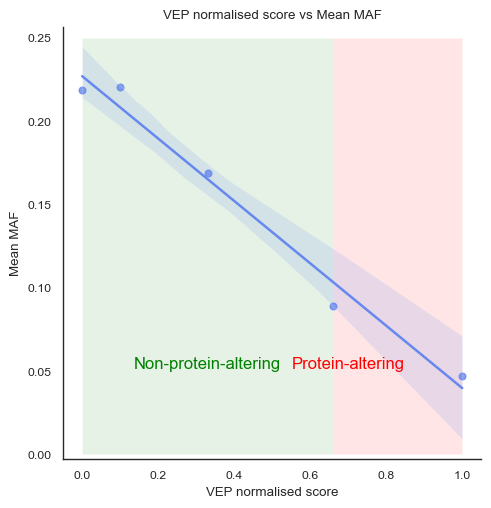

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = sns.lmplot(maf_vep_agg, x="normalisedScore", y="meanMAF")
protein_alt = patches.Rectangle(
    xy=(0.66, 0.00), height=0.25, width=0.34, linewidth=1, facecolor="red", zorder=-1, alpha=0.1
)
non_protein_alt = patches.Rectangle(
    xy=(0.00, 0.00), height=0.25, width=0.66, linewidth=1, facecolor="green", zorder=-1, alpha=0.1
)
ax = fig.axes[0, 0]
ax.add_patch(non_protein_alt)
ax.add_patch(protein_alt)
ax.text(
    0.7,
    0.05,
    "Protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="red",
)
ax.text(
    0.33,
    0.05,
    "Non-protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="green",
)
plt.xlabel("VEP normalised score")
plt.ylabel("Mean MAF")
plt.title("VEP normalised score vs Mean MAF")


<Axes: xlabel='majorPopulationMAF', ylabel='alteringStatus'>

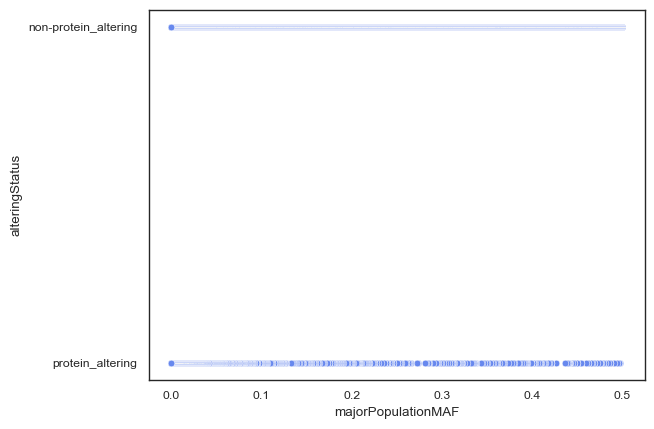

In [18]:
sns.scatterplot(
    data=maf_vep,
    x="majorPopulationMAF",
    y="alteringStatus",
)
